# Forecasting Future ED Demand 

## Overview 

This notebook contains the code to forecast future ED demand under 4 different scenarios:

1. 'do nothing': population grows but population health and health service capacity reamin unchanged
2. Increase 111 capacity by 10% in 2020
3. Increase 999 capacity by 10% in 2020
4. Increase GP capacity by 10% in 2020
5. If population health measures (People, Places, Lives) are less than the 2019 average, increase them by 0.2 points per year until they reach the 2019 average. 

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore') 

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import trained models 

In [3]:
with open('stacked_model_scaled.pkl','rb') as f:
    
    models, m1_features, m2_features = pkl.load(f)

**NB** if running notebook on colab the above code wont work. 
Instead, run the following cell: 

0.4519048888936743
0.4227235191823048
0.5791158305719311
0.6661669967506625
(1618, 14)


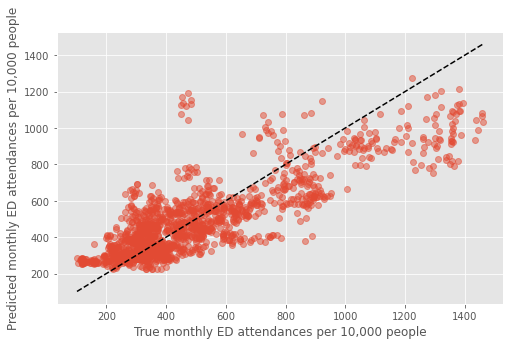

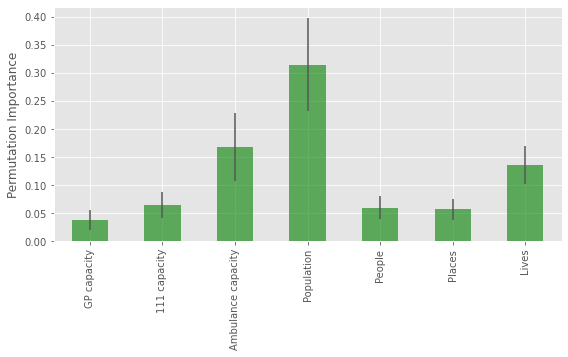

Combined training score: 0.8171513959512132


In [4]:
%run stacked_model.ipynb

models = [rf1,rf2,final]

## Import population forecasts 

In [5]:
population = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/pop_forecasts_scaled_new.csv',
                  index_col=0)

In [6]:
population

,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,...,2035,2036,2037,2038,2039,2040,2041,2042,2043,ccg
0,200.8447,202.9265,204.7996,206.5125,208.0446,209.3943,210.5565,211.5642,212.5387,213.4931,...,221.2491,222.2393,223.2383,224.2422,225.2318,226.1957,227.1281,228.0246,228.8859,A3A8R
1,209.5479,210.8074,211.8850,212.8265,213.6216,214.2545,214.7215,215.0593,215.4030,215.7479,...,219.0375,219.4856,219.9439,220.4162,220.8884,221.3468,221.7894,222.2189,222.6387,W2U3Z
2,149.4905,150.2535,150.9484,151.6046,152.1883,152.6870,153.1002,153.4384,153.7346,154.0150,...,156.6288,157.0287,157.4507,157.8919,158.3365,158.7785,159.2128,159.6398,160.0604,36L
3,181.1249,182.6084,183.9507,185.1905,186.3272,187.3571,188.2697,189.0749,189.8431,190.5932,...,197.0201,197.8779,198.7388,199.6013,200.4489,201.2717,202.0611,202.8162,203.5407,72Q
4,149.8001,151.1457,152.3376,153.3887,154.3113,155.1054,155.7686,156.3214,156.8646,157.4020,...,161.9110,162.4828,163.0498,163.6149,164.1693,164.7041,165.2164,165.7083,166.1828,93C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,21.5133,21.6203,21.6898,21.7321,21.7657,21.8065,21.8544,21.9101,21.9739,22.0439,...,22.4638,22.5006,22.5295,22.5486,22.5715,22.5996,22.6308,22.6632,22.6963,10R
77,48.9709,49.2387,49.4684,49.6714,49.8482,50.0060,50.1449,50.2665,50.3747,50.4696,...,50.9995,51.0625,51.1297,51.1994,51.2754,51.3581,51.4457,51.5383,51.6351,15A
78,56.8210,57.4154,57.9778,58.5240,59.0612,59.5859,60.1019,60.6047,61.0936,61.5704,...,64.7377,65.0715,65.3987,65.7217,66.0425,66.3625,66.6815,66.9986,67.3133,11N
79,55.9399,56.3600,56.7726,57.1821,57.5799,57.9658,58.3368,58.6904,59.0312,59.3577,...,61.6103,61.8668,62.1228,62.3799,62.6334,62.8819,63.1262,63.3669,63.6048,11X


## Import 2019 data as baseline 

In [7]:
baseline = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_2019_new.csv',
                  index_col=0)

In [8]:
baseline.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
                    if '/' in c else c for c in baseline.columns]

In [9]:
baseline

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives
0,00Q,Jan,347.450401,275.144606,276.797526,223.661852,4665.289367,1044.377666,14.9084,96.0,99.5,94.6
1,00Q,Feb,311.886541,253.462976,247.201714,198.606966,4060.932092,972.136514,14.9084,96.0,99.5,94.6
2,00Q,Mar,317.916884,277.724317,259.446256,208.037004,4191.127150,1056.317244,14.9084,96.0,99.5,94.6
3,00Q,Apr,326.639691,286.837872,261.284595,207.529233,3765.259854,1068.458050,14.9084,96.0,99.5,94.6
4,00Q,May,331.225629,287.382197,263.684592,207.844258,3888.881436,1085.294197,14.9084,96.0,99.5,94.6
...,...,...,...,...,...,...,...,...,...,...,...,...
907,X2C4Y,Aug,281.008273,253.093792,459.652700,306.843650,3982.517935,390.405530,44.0337,93.3,98.3,97.6
908,X2C4Y,Sep,263.936917,240.868701,453.078703,305.262399,4598.750502,388.679580,44.0337,93.3,98.3,97.6
909,X2C4Y,Oct,286.454848,254.680032,488.348051,327.202669,5225.611293,391.268506,44.0337,93.3,98.3,97.6
910,X2C4Y,Nov,326.984206,276.374619,499.497654,306.953594,4606.948769,389.542555,44.0337,93.3,98.3,97.6


## Functions 

Model predicts monthly ED attendances per 10,000 people

To forecast raw numbers, need to multiply predicted value by population/10,000

In [10]:
def stacked_predict(X, models, m1_features, m2_features):
    
    rf1,rf2,final = models
    
    y_pred_1 = rf1.predict(X[m1_features])

    y_pred_2 = rf2.predict(X[m2_features])

    X_f = np.vstack([y_pred_1, y_pred_2]).T
    
    preds = final.predict(X_f)
    
    return preds

In [11]:
def forecast(data, pop, year, models, m1_features, m2_features):
    
    # model = reg
    
    data = data.merge(pop[[str(year),'ccg']], 
                      left_on = 'ccg', right_on='ccg')
    
    data['population'] = data[str(year)]#*10000
    
    X = data.drop(['ae_attendances_attendances','ccg',\
                   'month',str(year),'ccg'], axis=1)
    
    preds = stacked_predict(X, models, m1_features, m2_features)
    
    preds = preds*data['population'].values
    
    return preds

In [12]:
def sum_by_month(results):

    to_plot = []

    months = ['Jan','Feb','Mar','Apr','May','Jun',\
              'Jul','Aug','Sep','Oct','Nov','Dec']

    for month in months:

        res = results.loc[results.month==month]
        to_plot.append(np.mean(res[res.columns[2:]].values, axis=0))

    to_plot = np.array(to_plot).T

    points = []

    for row in to_plot:

        points.extend(row)
        
    return points

### List to store scenario results 

In [13]:
scenario_results = []

### Scaling factor for capacity increase 

In [14]:
F=1.1

## Scenario 1: do nothing 

In [15]:
results = pd.DataFrame()
results['ccg'] = baseline['ccg']
results['month'] = baseline['month']
results['2019'] = baseline['ae_attendances_attendances']*baseline['population']

for year in np.arange(2020,2028):

    preds = forecast(baseline,population,year,models,m1_features,m2_features)
    
    results[str(year)] = preds

In [17]:
scenario_results.append(results)

## Scenario 2: increase 111 capacity

In [18]:
results = pd.DataFrame()
results['ccg'] = baseline['ccg']
results['month'] = baseline['month']
results['2019'] = baseline['ae_attendances_attendances']*baseline['population']

dta = baseline.copy()

for year in np.arange(2020,2028):

    dta['111_111_offered'] = baseline['111_111_offered'].values*F

    preds = forecast(dta,population,year,models,m1_features,m2_features)
    
    results[str(year)] = preds

In [20]:
scenario_results.append(results)

## Scenario 3: increase 999 capacity

In [21]:
results = pd.DataFrame()
results['ccg'] = baseline['ccg']
results['month'] = baseline['month']
results['2019'] = baseline['ae_attendances_attendances']*baseline['population']

dta = baseline.copy()

for year in np.arange(2020,2028):
    
    dta['amb_sys_answered'] = baseline['amb_sys_answered'].values*F

    preds = forecast(dta,population,year,models,m1_features,m2_features)
    
    results[str(year)] = preds

In [23]:
scenario_results.append(results)

## Scenario 4: increase GP capacity

In [24]:
results = pd.DataFrame()
results['ccg'] = baseline['ccg']
results['month'] = baseline['month']
results['2019'] = baseline['ae_attendances_attendances']*baseline['population']

dta = baseline.copy()

for year in np.arange(2020,2028):
    
    dta['gp_appt_available'] = baseline['gp_appt_available'].values*F

    preds = forecast(dta,population,year,models,m1_features,m2_features)
    
    results[str(year)] = preds

In [26]:
scenario_results.append(results)

## Scenario 5: health of population at 2019

In [27]:
results = pd.DataFrame()
results['ccg'] = baseline['ccg']
results['month'] = baseline['month']
results['2019'] = baseline['ae_attendances_attendances']*baseline['population']

dta = baseline.copy()


for year in np.arange(2020,2028):
    
    dta['People'] = [p+0.2 if p<np.mean(baseline.People.values) else p for p in dta.People.values]
    dta['Places'] = [p+0.2 if p<np.mean(baseline.Places.values) else p for p in dta.Places.values]
    dta['Lives'] = [p+0.2 if p<np.mean(baseline.Lives.values) else p for p in dta.Lives.values]

    preds = forecast(dta,population,year,models,m1_features,m2_features)
    
    results[str(year)] = preds

In [29]:
scenario_results.append(results)

## Plot 

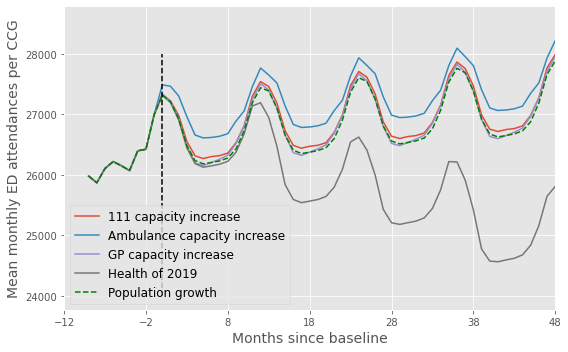

In [30]:
fig,ax = plt.subplots(figsize=(8,5))

scenarios = ['Population growth','111 capacity increase',
            'Ambulance capacity increase','GP capacity increase', 'Health of 2019']

for i,results in enumerate(scenario_results):
    
    if i==0:
        
        continue
    
    points = sum_by_month(results)
    
    points_series = pd.Series(points)
    
    plt.plot(np.arange(-12, 96),
             points_series.rolling(window=4).mean().to_list()[:], 
             label = f'{scenarios[i]}')
    
    
points = sum_by_month(scenario_results[0])

points_series = pd.Series(points)
    
plt.plot(np.arange(-12, 96),
         points_series.rolling(window=4).mean().to_list()[:],
         'g--', label = f'{scenarios[0]}')

    
y = np.arange(24000,29000,1000)    
plt.plot(np.zeros(len(y)),y, 'k--')

plt.legend(loc = 'lower left', fontsize=12)
plt.ylabel('Mean monthly ED attendances per CCG', fontsize=14)
plt.xlabel('Months since baseline', fontsize=14)
plt.xlim(0,48)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(-12, 50, 6))

#plt.ylim(24000,27000)
plt.tight_layout()
plt.savefig('forecast_scaled.png', dpi=300)
plt.show()